### Import the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import sklearn
import seaborn as sb
from sklearn.preprocessing import LabelEncoder

from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from graphviz import Source
from sklearn import metrics

from sklearn.model_selection import GridSearchCV
import time

### Reading data

In [2]:
#Reading the data
df = pd.read_csv("winequality-red.csv")
df.rename(columns={"fixed acidity":"fixed_acidity", "residual sugar":"residual_sugar","volatile acidity":"volatile_acidity", "citric acid": "citric_acid", "free sulfur dioxide":"free_sulfur_dioxide","total sulfur dioxide":"total_sulfur_dioxide"}, inplace= True)
df.shape

(1599, 12)

### Check data details

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         1599 non-null   float64
 1   volatile_acidity      1599 non-null   float64
 2   citric_acid           1599 non-null   float64
 3   residual_sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free_sulfur_dioxide   1599 non-null   float64
 6   total_sulfur_dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [4]:
df.isnull().sum() # no null or Nan values.

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [5]:
df.describe(include='all')

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


### Preprocessing of data

In [6]:
#labeling the column "quality"
bins = (2, 6.5, 8)
group_names = ['bad', 'good']
df['quality'] = pd.cut(df['quality'], bins = bins, labels = group_names)

In [7]:
label_quality = LabelEncoder()
df['quality'] = label_quality.fit_transform(df['quality'])

In [8]:
df['quality'].value_counts()

0    1382
1     217
Name: quality, dtype: int64

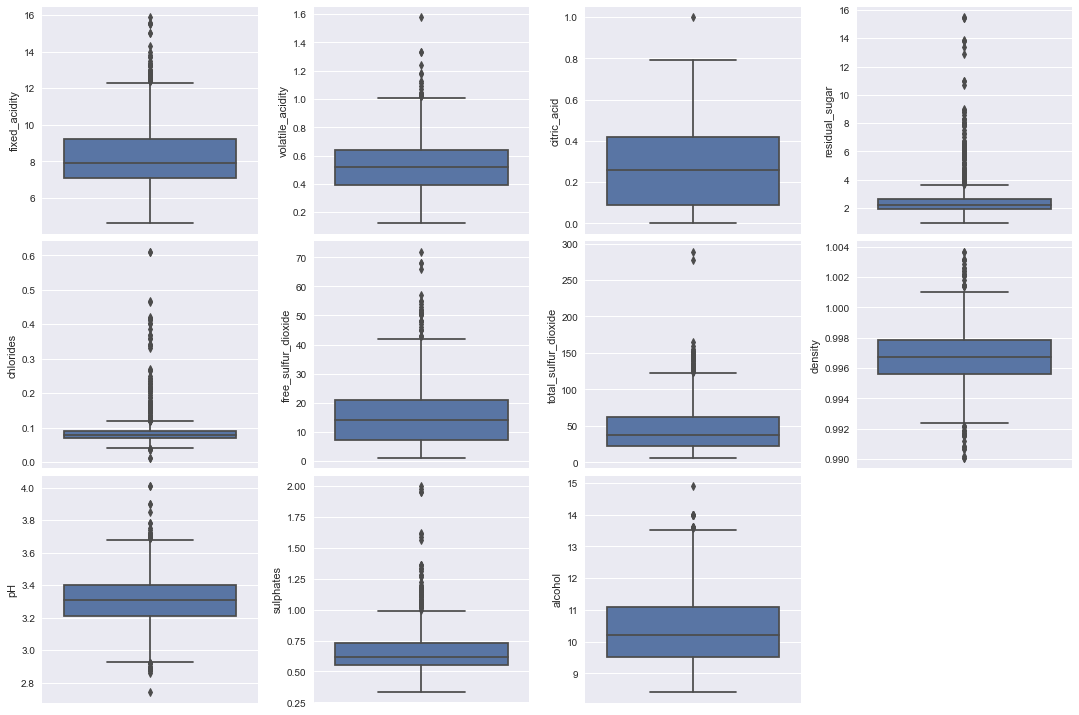

In [9]:
#Plotting boxplots to see if there are any outliers in our data (considering data betwen 25th and 75th percentile as non outlier)
fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(15, 10))
ax = ax.flatten()
index = 0
for i in df.columns:
  if i != 'quality':
    sb.boxplot(y=i, data=df, ax=ax[index])
    index +=1
plt.tight_layout(pad=0.4)
ax[11].set_axis_off()
plt.show()

In [10]:
#Remove outliers
#For each column, first it computes the Z-score of each value in the column, relative to the column mean and standard deviation.
#Then is takes the absolute of Z-score because the direction does not matter, only if it is below the threshold.
#all(axis=1) ensures that for each row, all column satisfy the constraint.
#Finally, result of this condition is used to index the dataframe.

df = df[(np.abs(zscore(df))<3).all(axis=1)]

### Separating dependent and independent variables

In [11]:
x = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [12]:
sc = StandardScaler()
x_scaled = sc.fit_transform(x)

### Splitting test set and training set

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled,y,test_size = 0.25,random_state = 0)

In [14]:
pd.Series(y_train).value_counts()

0    942
1    151
Name: quality, dtype: int64

### Normalizing the training set

In [15]:
smote = SMOTE(random_state = 0)
x_oversample, y_oversample = smote.fit_resample(x_train, y_train)

In [16]:
pd.Series(y_oversample).value_counts()

1    942
0    942
Name: quality, dtype: int64

# Logistic Regression

### Raw Data

In [17]:
start_lr = time.time()
logReg = LogisticRegression()
logReg.fit(x_train, y_train)
y_pred_logReg = logReg.predict(x_test)
end_lr = time.time()

In [18]:
print(classification_report(y_test, y_pred_logReg))
print('Accuracy is : ', accuracy_score(y_test, y_pred_logReg))
print(confusion_matrix(y_test, y_pred_logReg))
print('Runtime is : ',end_lr - start_lr)

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       315
           1       0.60      0.48      0.53        50

    accuracy                           0.88       365
   macro avg       0.76      0.71      0.73       365
weighted avg       0.88      0.88      0.88       365

Accuracy is :  0.8849315068493151
[[299  16]
 [ 26  24]]
Runtime is :  0.018003463745117188


### Oversampled

In [19]:
start_lr_o = time.time()
logReg = LogisticRegression()
logReg.fit(x_oversample, y_oversample)
y_pred_logReg_o = logReg.predict(x_test)
end_lr_o = time.time()

In [20]:
print(classification_report(y_test, y_pred_logReg_o))
print('Accuracy is : ', accuracy_score(y_test, y_pred_logReg_o))
print(confusion_matrix(y_test, y_pred_logReg_o))
print('Runtime is : ',end_lr_o - start_lr_o)

              precision    recall  f1-score   support

           0       0.96      0.79      0.87       315
           1       0.38      0.80      0.52        50

    accuracy                           0.79       365
   macro avg       0.67      0.80      0.69       365
weighted avg       0.88      0.79      0.82       365

Accuracy is :  0.7945205479452054
[[250  65]
 [ 10  40]]
Runtime is :  0.039006710052490234


# K-Nearest Neighbors

### Raw Data

In [21]:
start_knn = time.time()
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
y_pred_knn = knn.predict(x_test)
end_knn = time.time()

In [22]:
print(classification_report(y_test, y_pred_knn))
print('Accuracy is : ', accuracy_score(y_test, y_pred_knn))
print(confusion_matrix(y_test, y_pred_knn))
print('Runtime is : ',end_knn - start_knn)

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       315
           1       0.56      0.50      0.53        50

    accuracy                           0.88       365
   macro avg       0.74      0.72      0.73       365
weighted avg       0.87      0.88      0.87       365

Accuracy is :  0.8767123287671232
[[295  20]
 [ 25  25]]
Runtime is :  0.044507503509521484


### Oversampled

In [23]:
start_knn_o = time.time()
knn = KNeighborsClassifier()
knn.fit(x_oversample, y_oversample)
y_pred_knn_o = knn.predict(x_test)
end_knn_o = time.time()

In [24]:
print(classification_report(y_test, y_pred_knn_o))
print('Accuracy is : ', accuracy_score(y_test, y_pred_knn_o))
print(confusion_matrix(y_test, y_pred_knn_o))
print('Runtime is : ', end_knn_o - start_knn_o)

              precision    recall  f1-score   support

           0       0.96      0.77      0.86       315
           1       0.36      0.82      0.50        50

    accuracy                           0.78       365
   macro avg       0.66      0.79      0.68       365
weighted avg       0.88      0.78      0.81       365

Accuracy is :  0.7753424657534247
[[242  73]
 [  9  41]]
Runtime is :  0.08351421356201172


# Decision Tree

### Raw Data

In [25]:
start_dt = time.time()
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(x_train, y_train)
y_pred_dt = dt.predict(x_test)
end_dt = time.time()

In [26]:
print(classification_report(y_test, y_pred_dt))
print('Accuracy is : ', accuracy_score(y_test, y_pred_dt))
print(confusion_matrix(y_test, y_pred_dt))
print('Runtime is : ', end_dt - start_dt)

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       315
           1       0.65      0.62      0.63        50

    accuracy                           0.90       365
   macro avg       0.79      0.78      0.79       365
weighted avg       0.90      0.90      0.90       365

Accuracy is :  0.9013698630136986
[[298  17]
 [ 19  31]]
Runtime is :  0.008501291275024414


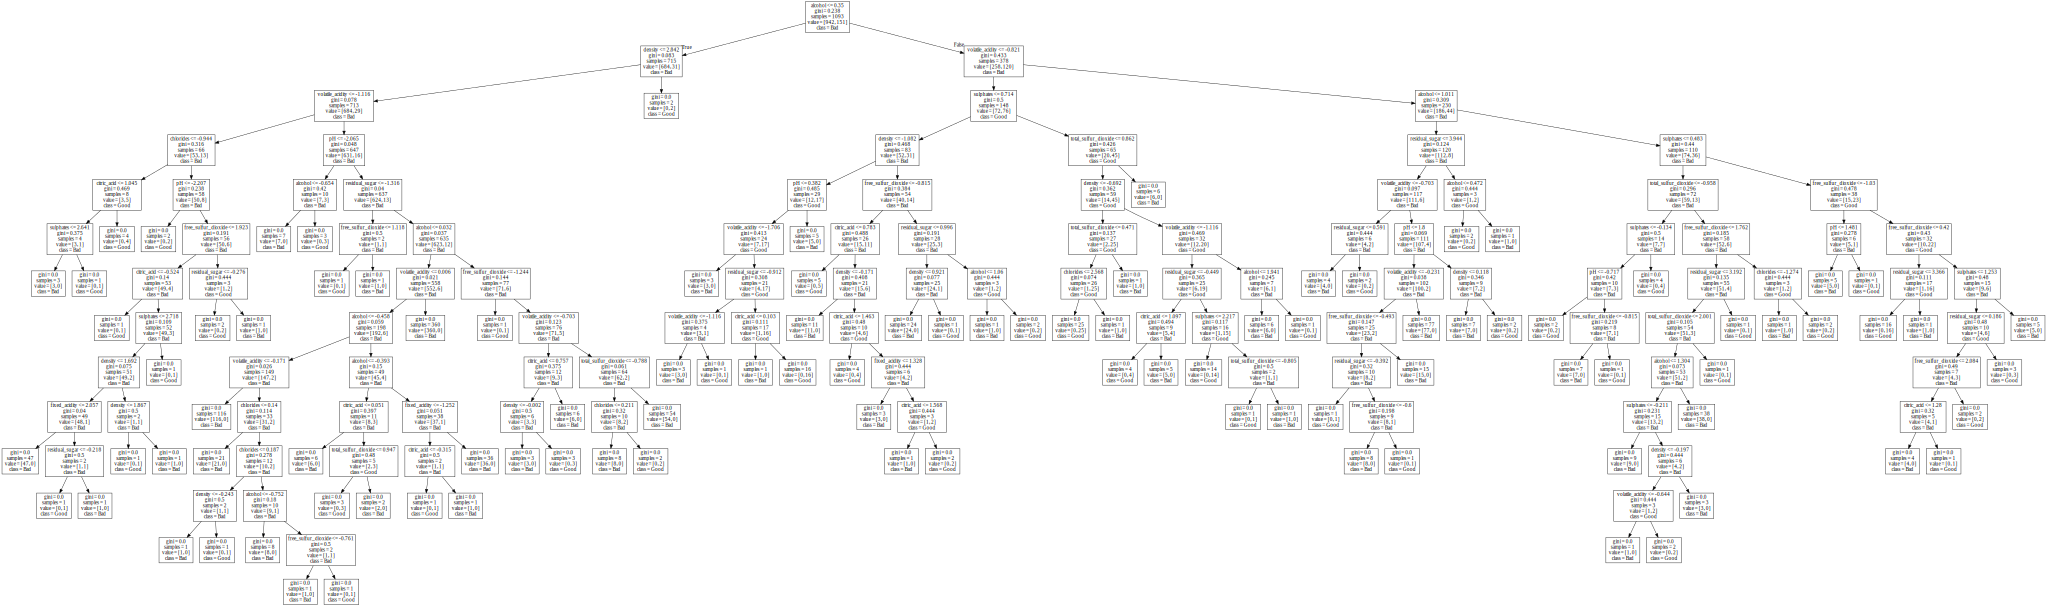

In [27]:
y_pred_dt=dt.predict(x_test)
Source(tree.export_graphviz(dt, out_file=None, class_names=["Bad","Good"], feature_names = x.columns))

### Oversampled

In [28]:
start_dt_o = time.time()
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(x_oversample, y_oversample)
y_pred_dt_o = dt.predict(x_test)
end_dt_o = time.time()

In [29]:
print(classification_report(y_test, y_pred_dt_o))
print('Accuracy is : ', accuracy_score(y_test, y_pred_dt_o))
print(confusion_matrix(y_test, y_pred_dt_o))
print('Runtime is : ', end_dt_o - start_dt_o)

              precision    recall  f1-score   support

           0       0.93      0.90      0.91       315
           1       0.48      0.58      0.52        50

    accuracy                           0.85       365
   macro avg       0.70      0.74      0.72       365
weighted avg       0.87      0.85      0.86       365

Accuracy is :  0.8547945205479452
[[283  32]
 [ 21  29]]
Runtime is :  0.02250361442565918


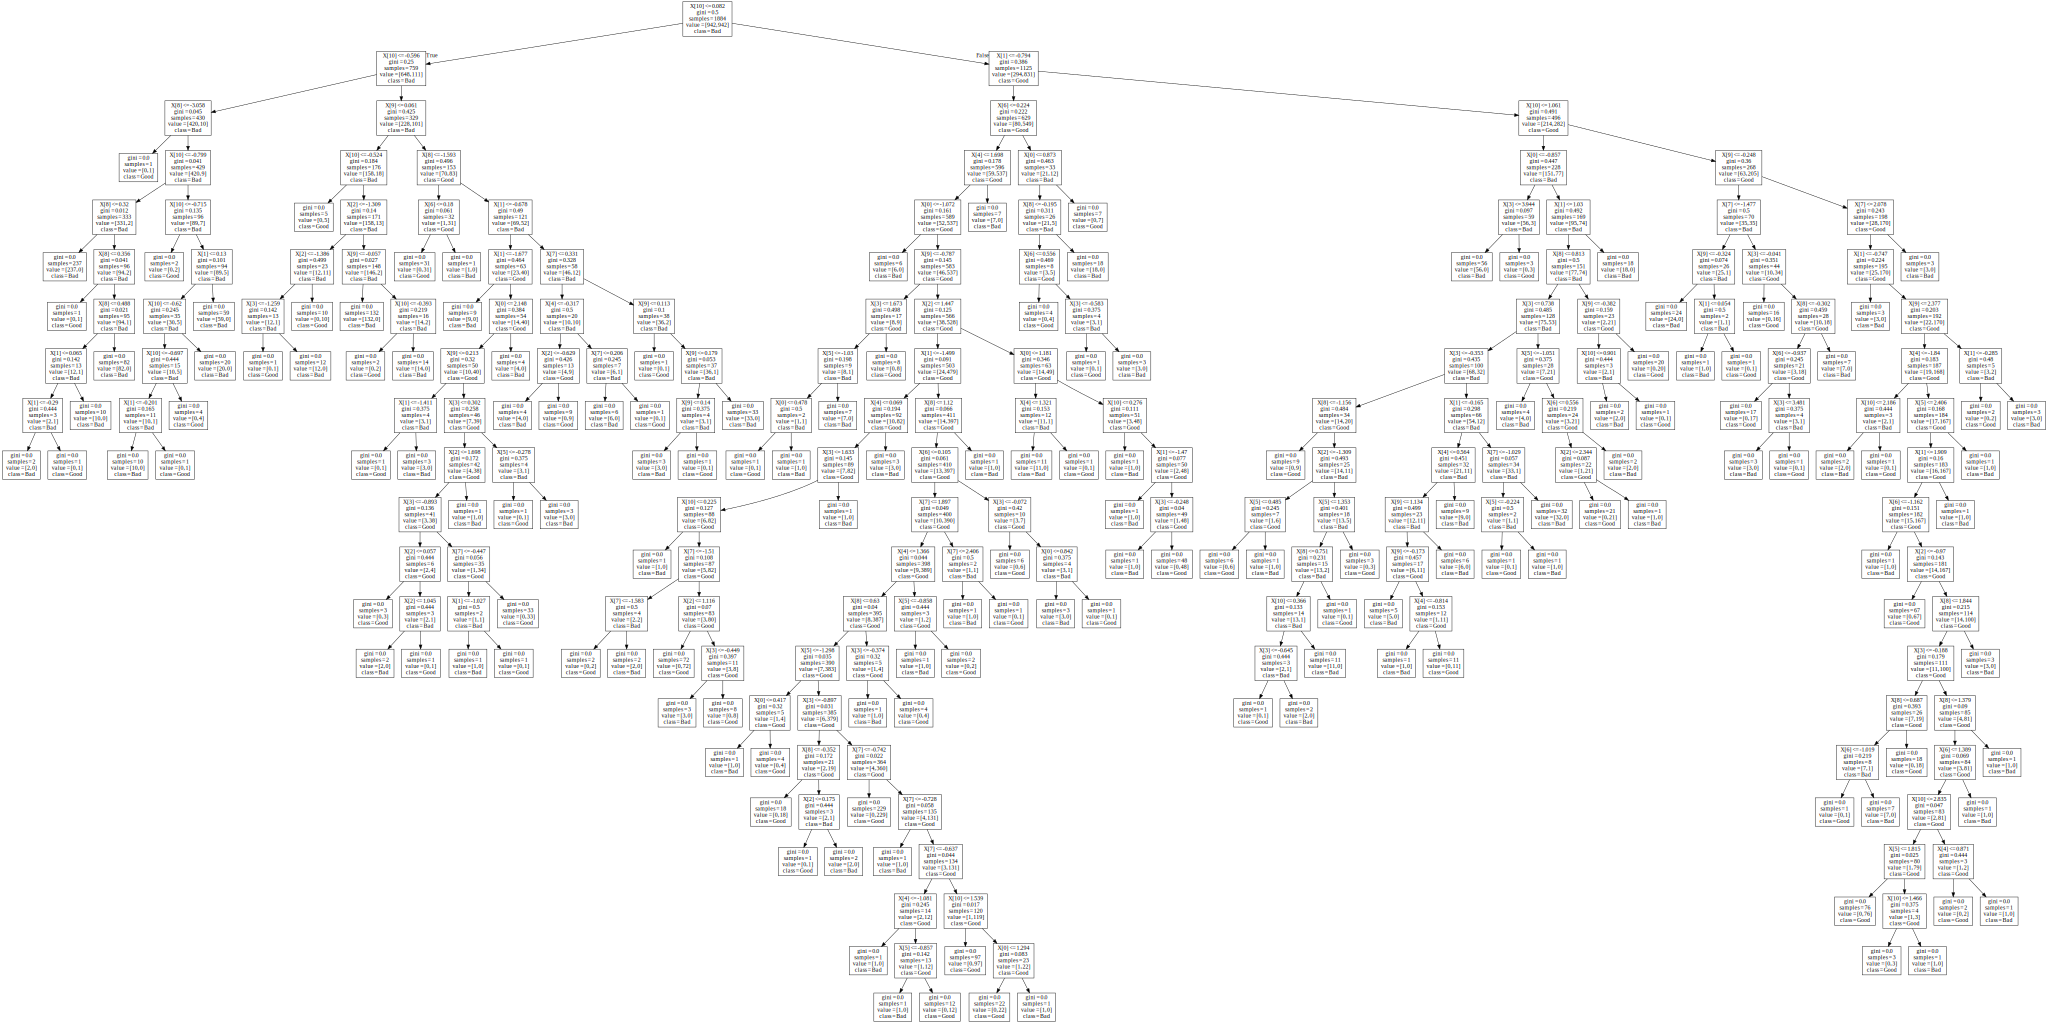

In [30]:
y_pred_dt_o=dt.predict(x_test)
Source(tree.export_graphviz(dt, out_file=None, class_names=["Bad","Good"]))

# Conclusion of results

In [31]:
conclusion = pd.DataFrame({'Model': ["Logistics Regression","K-Nearest Neighbours","Decision Tree"],
                           'Accuracy before oversampling': [accuracy_score(y_test,y_pred_logReg),accuracy_score(y_test,y_pred_knn),accuracy_score(y_test, y_pred_dt)],
                           'Accuracy after oversampling': [accuracy_score(y_test,y_pred_logReg_o),accuracy_score(y_test,y_pred_knn_o),accuracy_score(y_test, y_pred_dt_o)]})
print (conclusion.to_string(index=False))

                Model  Accuracy before oversampling  Accuracy after oversampling
 Logistics Regression                      0.884932                     0.794521
 K-Nearest Neighbours                      0.876712                     0.775342
        Decision Tree                      0.901370                     0.854795


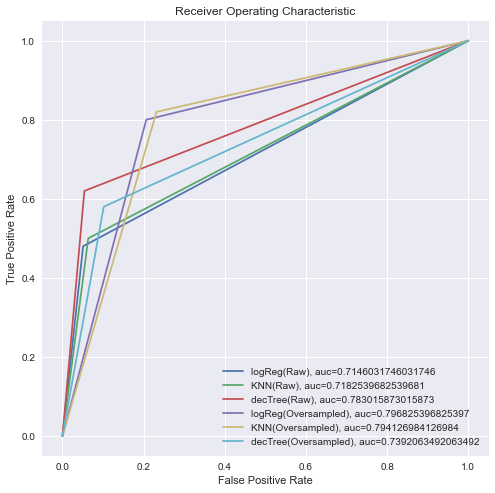

In [32]:
#Plotting of ROC
from sklearn import metrics
plt.figure(figsize=(8,8))
fpr1, tpr1, _ = metrics.roc_curve(y_test,  y_pred_logReg)
auc1 = metrics.roc_auc_score(y_test, y_pred_logReg)
plt.plot(fpr1,tpr1,label="logReg(Raw), auc="+str(auc1))
fpr2, tpr2, _ = metrics.roc_curve(y_test, y_pred_knn)
auc2 = metrics.roc_auc_score(y_test, y_pred_knn)
plt.plot(fpr2,tpr2,label="KNN(Raw), auc="+str(auc2))
fpr3, tpr3, _ = metrics.roc_curve(y_test, y_pred_dt)
auc3 = metrics.roc_auc_score(y_test, y_pred_dt)
plt.plot(fpr3,tpr3,label="decTree(Raw), auc="+str(auc3))

fpr4, tpr4, _ = metrics.roc_curve(y_test,  y_pred_logReg_o)
auc4 = metrics.roc_auc_score(y_test, y_pred_logReg_o)
plt.plot(fpr4,tpr4,label="logReg(Oversampled), auc="+str(auc4))
fpr5, tpr5, _ = metrics.roc_curve(y_test, y_pred_knn_o)
auc5 = metrics.roc_auc_score(y_test, y_pred_knn_o)
plt.plot(fpr5,tpr5,label="KNN(Oversampled), auc="+str(auc5))
fpr6, tpr6, _ = metrics.roc_curve(y_test, y_pred_dt_o)
auc6 = metrics.roc_auc_score(y_test, y_pred_dt_o)
plt.plot(fpr6,tpr6,label="decTree(Oversampled), auc="+str(auc6))

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc=4)
plt.show()